In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#numeric standardized

In [45]:
df = pd.read_csv("major-crime-indicators.csv")

#keep just 2021 data (relates best to population dataset)
df.drop(df[df['OCC_YEAR'] <= 2020].index, inplace=True)
df.drop(df[df['OCC_YEAR'] >= 2022].index, inplace=True)

#drop null values
df.drop(df[df['HOOD_158'] == 'NSA'].index,inplace=True)
df = df.dropna()

df_merge = df.copy() 

#send neighborhood to numeric for merging (and not creatign dummies)
df_merge['HOOD_158'] = pd.to_numeric(df_merge['HOOD_158'])

#create dummy variables
df_merge = pd.get_dummies(df_merge)

#drop one column for multicollinearity
df_merge = df_merge.drop('MCI_CATEGORY_Theft Over', axis = 1)

#rename columns for readability
df_merge = df_merge[['HOOD_158', 'MCI_CATEGORY_Assault', 'MCI_CATEGORY_Auto Theft', 'MCI_CATEGORY_Break and Enter', 'MCI_CATEGORY_Robbery']]
df_merge.columns = ['Neighborhood', '%_Assault', '%_Auto_Theft', '%_Break_And_Enter', '%_Robbery']
df_merge = df_merge.map(lambda x: x.strip() if isinstance(x, str) else x)

pop_df = pd.read_excel("158-model - Copy.xlsx", header=None)
pop_df = pop_df.T.reset_index(drop=True)

pop_df.columns = ['Neighborhood', 'Population', 'Avg_Age', 'Avg_Income', 'Low_Income_Prevalence', 'Gini_Index', 'Avg_Household_income', '%_Core_Housing_Need', 'Avg_Owned_Shelter_Cost', '%_Spending_Over_30%_Income_On_Housing', 'Avg_Rent_Shelter_Cost', 'Workforce_Participation_Rate', 'Unemployment_Rate', '%_High_School_Diploma', '%_Postsecondary_Diploma', '%_Suitable_Housing']
pop_df = pop_df.iloc[1:]

crime_count = df_merge.groupby("Neighborhood").size().reset_index(name="Crimes_Count")
crime_type_mean = df_merge.groupby("Neighborhood").mean()

merged_df1 = pd.merge(pop_df, crime_count, on='Neighborhood')
merged_df = pd.merge(merged_df1, crime_type_mean, on='Neighborhood')

merged_df["CrimeRate_per10k"] = (merged_df["Crimes_Count"] / merged_df["Population"]) * 10000

#create risk indicator based on crimes/population
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merged_df['Neighborhood_Risk'] = scaler.fit_transform(merged_df[['CrimeRate_per10k']])

merged_df['Neighborhood'] = merged_df['Neighborhood_Risk']
merged_df = merged_df.drop(['Neighborhood_Risk', 'Crimes_Count', 'CrimeRate_per10k'], axis = 1)
merged_df = merged_df.rename(columns={'Neighborhood': 'Neighborhood_Risk'})

merged_df = merged_df.astype(float)

merged_df

,Neighborhood_Risk,Population,Avg_Age,Avg_Income,Low_Income_Prevalence,Gini_Index,Avg_Household_income,%_Core_Housing_Need,Avg_Owned_Shelter_Cost,%_Spending_Over_30%_Income_On_Housing,Avg_Rent_Shelter_Cost,Workforce_Participation_Rate,Unemployment_Rate,%_High_School_Diploma,%_Postsecondary_Diploma,%_Suitable_Housing,%_Assault,%_Auto_Theft,%_Break_And_Enter,%_Robbery
0,0.518225,33300.0,40.5,36800.0,8.7,0.3,104500.0,9.3,1692.0,34.1,1376.0,63.5,14.3,0.291379,0.525690,0.817757,0.256785,0.524008,0.104384,0.055324
1,0.153421,31345.0,37.8,31400.0,15.6,0.3,86200.0,16.0,1678.0,32.3,1300.0,56.0,17.7,0.303060,0.419217,0.688912,0.604905,0.204360,0.046322,0.136240
2,0.159222,9850.0,41.0,39040.0,11.8,0.3,101300.0,10.4,1712.0,30.9,1244.0,59.8,16.6,0.284431,0.494012,0.845679,0.491525,0.364407,0.067797,0.050847
3,0.170992,10375.0,41.9,39240.0,13.5,0.3,90000.0,8.2,1574.0,36.7,1219.0,60.2,13.9,0.308915,0.478137,0.854246,0.376923,0.315385,0.215385,0.076923
4,0.202491,9355.0,39.6,37280.0,12.4,0.3,94600.0,12.1,1646.0,29.3,1328.0,57.1,18.5,0.339574,0.433183,0.820031,0.488550,0.366412,0.068702,0.053435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0.804379,12645.0,34.5,69300.0,24.3,0.5,99800.0,15.5,2260.0,55.9,2088.0,73.8,13.3,0.152891,0.820557,0.872070,0.604128,0.033771,0.213884,0.093809
154,0.183494,23180.0,39.6,54350.0,11.2,0.3,103700.0,10.5,1968.0,41.2,1518.0,69.8,14.0,0.212634,0.589406,0.902307,0.578947,0.105263,0.253289,0.036184
155,0.169053,12380.0,41.9,54800.0,10.0,0.4,111500.0,10.7,1922.0,42.3,1598.0,67.7,13.8,0.207444,0.605084,0.934967,0.642857,0.064935,0.129870,0.142857
156,0.168245,15885.0,39.2,55400.0,18.5,0.4,85400.0,12.3,2170.0,46.7,1724.0,74.6,13.0,0.146191,0.799245,0.880170,0.609137,0.065990,0.253807,0.060914


In [53]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from ISLP.models import summarize

X_columns = [
    'Population','Avg_Age','Avg_Income','Low_Income_Prevalence','Gini_Index',
    'Avg_Household_income','%_Core_Housing_Need','%_Spending_Over_30%_Income_On_Housing',
    'Avg_Rent_Shelter_Cost','Workforce_Participation_Rate','Unemployment_Rate',
    '%_High_School_Diploma','%_Postsecondary_Diploma','%_Suitable_Housing'
]

#vif calculation function that measures multicollinearity
def compute_vif(X):
    X_temp = X.copy()
    X_temp = X_temp.assign(const=1) 
    vif = pd.DataFrame({
        'feature': X.columns,
        'VIF': [variance_inflation_factor(X_temp.values, i) for i in range(X.shape[1])]
    }).sort_values('VIF', ascending=False)
    return vif

X = merged_df[X_columns]
vif_values = compute_vif(X)

#printing high VIF scores (above 10)
high_colinearity_features = []
for index, row in vif_values.iterrows():
    if row['VIF'] >= 10:
        high_colinearity_features.append(row['feature'])
        print(f"{row['feature']}: {row['VIF']}")

print()
#removing columns with high VIF + similar columns
X_columns.remove('Avg_Household_income')
X_columns.remove('%_Postsecondary_Diploma')
X = merged_df[X_columns]

vif_values = compute_vif(X)
print(vif_values)

Avg_Household_income: 45.27508750979255
Avg_Income: 40.09138938636395
%_High_School_Diploma: 15.587568488632135
%_Postsecondary_Diploma: 10.484748224471115

                                  feature       VIF
10                  %_High_School_Diploma  9.203513
2                              Avg_Income  8.492314
8            Workforce_Participation_Rate  6.717830
4                              Gini_Index  5.663352
9                       Unemployment_Rate  5.549256
11                     %_Suitable_Housing  4.281316
7                   Avg_Rent_Shelter_Cost  4.268111
3                   Low_Income_Prevalence  4.167332
1                                 Avg_Age  3.780286
5                     %_Core_Housing_Need  3.741964
6   %_Spending_Over_30%_Income_On_Housing  3.046928
0                              Population  1.201482


In [54]:
y_columns = ['Neighborhood_Risk']
y = merged_df[y_columns]

#remove high p-value features iteratively
while True:
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    
    #find the feature with the highest p-value
    p_values = model.pvalues.drop('const')
    max_p_value = p_values.max()
    
    #if the highest p-value is above the threshold, remove that feature
    if max_p_value > 0.05:
        feature_to_remove = p_values.idxmax()
        print(f"Removing feature '{feature_to_remove}' with p-value {max_p_value}")
        print("Current model R^2:", round(model.rsquared, 3))
        print()
        X_columns.remove(feature_to_remove)
        
        #update training and testing sets
        X = merged_df[X_columns]
    else:
        break

Removing feature 'Avg_Rent_Shelter_Cost' with p-value 0.8131244719661266
Current model R^2: 0.437

Removing feature 'Gini_Index' with p-value 0.8069778458559278
Current model R^2: 0.437

Removing feature '%_Spending_Over_30%_Income_On_Housing' with p-value 0.48449301514973864
Current model R^2: 0.437

Removing feature 'Avg_Age' with p-value 0.4503112762498688
Current model R^2: 0.435

Removing feature '%_Core_Housing_Need' with p-value 0.13351872413370794
Current model R^2: 0.432

Removing feature 'Population' with p-value 0.19132053945161062
Current model R^2: 0.424



In [56]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Neighborhood_Risk   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     18.02
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           1.06e-15
Time:                        21:46:50   Log-Likelihood:                 122.05
No. Observations:                 158   AIC:                            -230.1
Df Residuals:                     151   BIC:                            -208.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -2.3625      0.383     -6.162      0.000      -3.120      -1.605
Avg_Income                    2.049e-06   5.35e-07      3.832      0.000    9.93e-07    3.11e-06
Low_Income_Prevalence            0.0203      0.003      6.638      0.000       0.014       0.026
Workforce_Participation_Rate     0.0146      0.002      6.164      0.000       0.010       0.019
Unemployment_Rate                0.0175      0.008      2.300      0.023       0.002       0.032
%_High_School_Diploma            1.5702      0.452      3.476      0.001       0.678       2.463
%_Suitable_Housing               0.6847      0.220      3.113      0.002       0.250       1.119
==============================================================================
Omnibus:                       86.709   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              450.033
Skew:                           2.009   Prob(JB):                     1.89e-98
Kurtosis:                      10.226   Cond. No.                     4.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
summarize(model)

,coef,std err,t,P>|t|
const,-2.362500,3.830000e-01,-6.162,0.000
Avg_Income,0.000002,5.350000e-07,3.832,0.000
Low_Income_Prevalence,0.020300,3.000000e-03,6.638,0.000
Workforce_Participation_Rate,0.014600,2.000000e-03,6.164,0.000
Unemployment_Rate,0.017500,8.000000e-03,2.300,0.023
%_High_School_Diploma,1.570200,4.520000e-01,3.476,0.001
%_Suitable_Housing,0.684700,2.200000e-01,3.113,0.002


In [58]:
print("R^2:", round(model.rsquared, 3))

R^2: 0.417


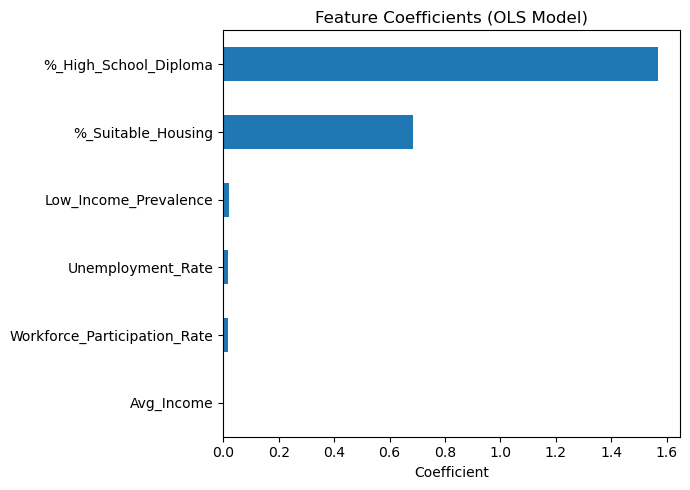

In [ ]:
#coefficient plot: what's driving crime risk
coef_df = model.params.drop('const').sort_values()
coef_df.plot(kind='barh', figsize=(7,5))
plt.title("Feature Coefficients (OLS Model)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

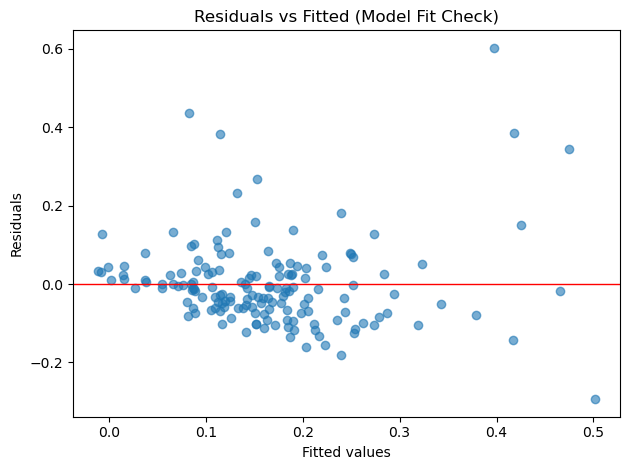

In [59]:
#residual plot: model fit check
residuals = model.resid
fitted = model.fittedvalues

plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(0, color='red', linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Model Fit Check)")
plt.tight_layout()
plt.show()